In [24]:
import os
import h5py
import numpy as np
from scipy.signal import decimate
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
VERBOSE = 0  # constant for debugging, higher number means more printing
TRAIN_VAL_SPLIT = 6  # number of train files per task, the rest for validation
DOWNSAMPLING_FACTOR = 10

In [4]:
def log(message: tuple, verbose_true: int, verbose_min):
    """Helper print function, based on verbose params."""
    if verbose_true >= verbose_min:
        for entry in message:
            print(entry, end=' ')
        print()

In [5]:
def load_data(filename):
    """Load data from .h5 file."""
    with h5py.File(filename, 'r') as f:
        data = f[next(iter(f.keys()))][()]
    return data

In [6]:
def data_loader(input_dir: str) -> tuple[np.ndarray, str]:
    """Generator for loading data and its filename from all .h5 files in a directory."""
    for file in os.listdir(input_dir):
        if not file.endswith('.h5'):
            continue
        path = os.path.join(input_dir, file)
        data = load_data(path)
        yield data, file

In [7]:
def create_data_file(data, output_dir, filename: str):
    """Create .h5 file with given data."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    with h5py.File(output_path, 'w') as f:
        f.create_dataset(filename.rsplit('.', 1)[0], data=data)

In [8]:
def get_file_info(filename: str) -> tuple[str, int, int]:
    filename = filename.rsplit('.', 1)[0].split('_')
    task, person_id, window = filename[-3], filename[-2], filename[-1]
    return task, int(window), int(person_id)

### Preprocessing

In [9]:
def downsample(data, factor):
    """Downsample data based on factor."""
    return decimate(data, factor, axis=1)

In [10]:
def get_means(data) -> np.ndarray:
    """Get means for every sensor dimension."""
    return np.mean(data, axis=1, keepdims=True)

In [11]:
def get_stds(data) -> np.ndarray:
    """Get standard deviations for every sensor dimension."""
    return np.std(data, axis=1, keepdims=True)

In [12]:
def z_score_normalize(data, means, stds):
    """Z-score normalization for every sensor dimension."""
    return (data - means) / stds

In [13]:
def downsample_and_save(input_dir, output_dir, factor, verbose):
    """Downsample data in each file and save them in a new file."""
    for data, file in data_loader(input_dir):
        data = downsample(data, factor)
        create_data_file(data, output_dir, f"ds_{file}")

In [14]:
def normalize_and_save(input_dir, output_dir, means, stds, verbose):
    """Normalize data in each file and save them in a new file."""
    for data, file in data_loader(input_dir):
        data = z_score_normalize(data, means, stds)
        create_data_file(data, output_dir, f"norm_{file}")

In [15]:
def concat_together(input_dir, train_val_split=TRAIN_VAL_SPLIT):
    """
    Concatenate data from files into a single time window of sensor readings.
    Also split to a train and validation sets.
    """
    train_data = None
    val_data = None
    for data, file in data_loader(input_dir):
        _, window, _ = get_file_info(file)
        if window <= train_val_split and train_data is None:
            train_data = data
        elif window <= train_val_split:
            train_data = np.concat((train_data, data), axis=1)
        elif val_data is None:
            val_data = data
        else:
            val_data = np.concat((train_data, data), axis=1)
    return train_data, val_data

In [15]:
downsample_and_save('fpd/Intra/train', 'fpd/Intra/train_ds', DOWNSAMPLING_FACTOR, VERBOSE)

In [16]:
data_train, _ = concat_together('fpd/Intra/train_ds')
means, stds = get_means(data_train), get_stds(data_train)

In [17]:
normalize_and_save('fpd/Intra/train_ds', 'fpd/Intra/train_ds_norm', means, stds, VERBOSE)

### Training

In [18]:
def concat_as_samples(input_dir, train_val_split=TRAIN_VAL_SPLIT):
    """
    Concatenate data from files, treating each data file as a window sample
    of sensor readings. Also split them to train and validation sets.
    """
    samples_train = []
    tasks_train = []
    ids_train = []
    samples_val = []
    tasks_val = []
    ids_val = []
    for data, file in data_loader(input_dir):
        task, window, person_id = get_file_info(file)
        if window <= train_val_split:
            samples_train.append(data)
            tasks_train.append(task)
            ids_train.append(person_id)
        else:
            samples_val.append(data)
            tasks_val.append(task)
            ids_val.append(person_id)
    return np.stack(samples_train), tasks_train, ids_train, np.stack(samples_val), tasks_val, ids_val

In [19]:
data_train, labels_train, ids_train, data_val, labels_val, ids_val = concat_as_samples('fpd/Intra/train_ds_norm')
print(np.shape(data_train))
print(np.shape(data_val))
print(labels_train)

(24, 248, 3563)
(8, 248, 3563)
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'math', 'math', 'math', 'math', 'math', 'math', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory']


#### Multiclass Logistic Regression

In [20]:
# Flatten the data: (24, 248, 3563) → (24, 248*3563)
X_train = data_train.reshape(len(data_train), -1)
X_val = data_val.reshape(len(data_val), -1)
print(np.shape(X_train))

# Encode string labels to integers
le = LabelEncoder()
y_train = le.fit_transform(labels_train)
y_val = le.transform(labels_val)
print(y_train)
print(y_val)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

(24, 883624)
[3 3 3 3 3 3 2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1]
[3 3 2 2 0 0 1 1]


In [21]:
class MulticlassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MulticlassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)  # No softmax here; CrossEntropyLoss does it

In [22]:
input_dim = X_train.shape[1]
num_classes = len(set(y_train))
model = MulticlassLogisticRegression(input_dim, num_classes)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [24]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/3, Loss: 1.6191
Epoch 2/3, Loss: 0.0000
Epoch 3/3, Loss: 0.0000


In [25]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    print(val_outputs)
    _, val_predictions = torch.max(val_outputs, 1)
    print('True classes     :', y_val_tensor)
    print('Model predictions:', val_predictions)
    accuracy = (val_predictions == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {accuracy.item():.4f}')

tensor([[-24461.3340, -31593.6523, -27134.4062,  39867.7227],
        [-26726.1582, -34143.8398, -31602.9805,  44225.4766],
        [ -1267.0527,   4743.0156,  15410.0732, -11358.7900],
        [ -1140.0105,   5702.3662,  15498.4160, -11827.9639],
        [ 12744.9209,   6473.7285,    751.5942,  -8384.6533],
        [ 12781.9229,   7078.9136,    271.4326,  -8672.8408],
        [  2960.7700,   8743.6084,  -3133.7996,  -3920.0940],
        [  2731.0901,   7727.7827,  -2810.1365,  -3386.3804]])
True classes     : tensor([3, 3, 2, 2, 0, 0, 1, 1])
Model predictions: tensor([3, 3, 2, 2, 0, 0, 1, 1])
Validation Accuracy: 1.0000


#### Logistic Regression with data dimensionality reduction

In [26]:
# Reshape: (samples, 248, 3563) → (samples, 248 * 3563)
X_train_flat = data_train.reshape(data_train.shape[0], -1)
X_val_flat = data_val.reshape(data_val.shape[0], -1)
print(np.shape(X_train_flat))

(24, 883624)


In [27]:
from sklearn.decomposition import PCA

# Reduce to 100 components (tune as needed)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Convert to PyTorch tensors for training
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)

In [28]:
input_dim = X_train_pca.shape[1]
num_classes = len(set(y_train))
model = MulticlassLogisticRegression(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    print(val_outputs)
    _, val_predictions = torch.max(val_outputs, 1)
    print('True classes     :', y_val_tensor)
    print('Model predictions:', val_predictions)
    accuracy = (val_predictions == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {accuracy.item():.4f}')

Epoch 10/30, Loss: 0.0048
Epoch 20/30, Loss: 0.0000
Epoch 30/30, Loss: 0.0000
tensor([[-4.3830e+02, -3.2800e+02, -2.0185e+02,  5.7335e+02],
        [-4.6638e+02, -3.3109e+02, -2.5749e+02,  6.3448e+02],
        [-7.7585e+01, -2.6321e+01,  3.1149e+02, -3.1182e+01],
        [-2.5840e+00,  3.1925e+01,  3.3680e+02, -3.2196e+01],
        [ 5.1223e+01, -4.0822e+01,  4.4065e+01, -2.2397e+02],
        [ 7.8299e+01, -1.0571e+01, -9.8372e-03, -2.3112e+02],
        [ 7.1537e+01,  1.9228e+02, -2.6392e+02,  6.2332e+01],
        [ 3.5009e+01,  1.7678e+02, -2.5466e+02,  6.2989e+01]])
True classes     : tensor([3, 3, 2, 2, 0, 0, 1, 1])
Model predictions: tensor([3, 3, 2, 2, 0, 0, 1, 1])
Validation Accuracy: 1.0000


### t-SNE data visualization

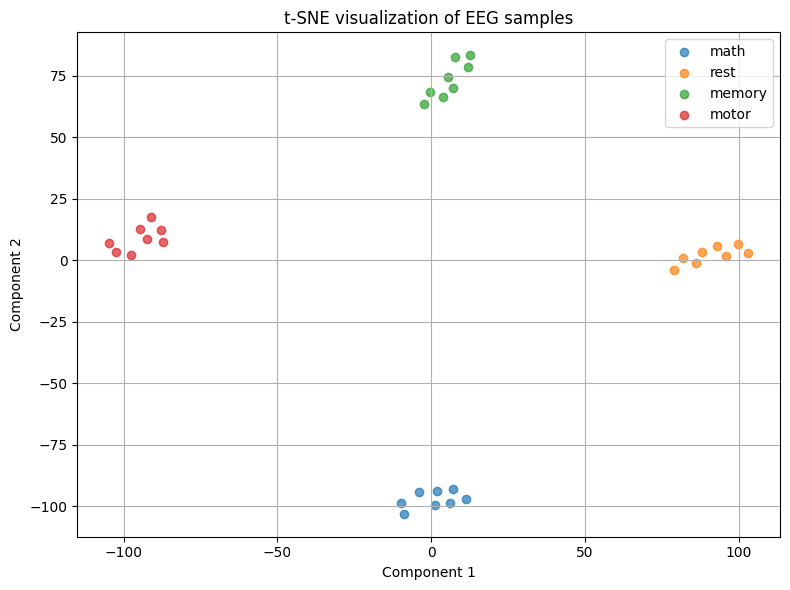

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine train and val for visualization
X_combined = np.vstack([X_train_flat, X_val_flat])
labels_combined = labels_train + labels_val

# Optional: PCA first for speed
X_combined_pca = PCA(n_components=10).fit_transform(X_combined)

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X_combined_pca)

# Plot
plt.figure(figsize=(8, 6))
for label in set(labels_combined):
    idx = [i for i, l in enumerate(labels_combined) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, alpha=0.7)
plt.legend()
plt.title("t-SNE visualization of EEG samples")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Cross Dataset Preprocessing

In [16]:
downsample_and_save('Cross/train', 'Cross/train_ds', DOWNSAMPLING_FACTOR, VERBOSE)
cr_data_train, _ = concat_together('Cross/train_ds')
cr_means, cr_stds = get_means(cr_data_train), get_stds(cr_data_train)
normalize_and_save('Cross/train_ds', 'Cross/train_ds_norm', cr_means, cr_stds, VERBOSE)

#### Logistic Regression on Cross Dataset

(48, 248, 3563)
(16, 248, 3563)
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory']
(48, 883624)
[3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1]
[3 3 3 3 2 2 2 2 0 0 0 0 1 1 1 1]
Epoch 1/10, Train Loss: 1.5221, Val Loss: 0.2793
Epoch 2/10, Train Loss: 0.4490, Val Loss: 0.1246
Epoch 3/10, Train Loss: 0.2249, Val Loss: 0.0414
Epoch 4/10, Train Loss: 0.0895, Val Loss: 0.0187
Epoch 5/10, Train Loss: 0.0351, Val Loss: 0.0108
Epoch 6/10, Train Loss: 0.0153, Val Loss: 0.0066
Epoch 7/10, Train Loss: 0.0075, Val Loss: 0.0042
Epoch 8/10, Train Loss: 0.0040, Val Loss: 0.0028
Epoch 9/1

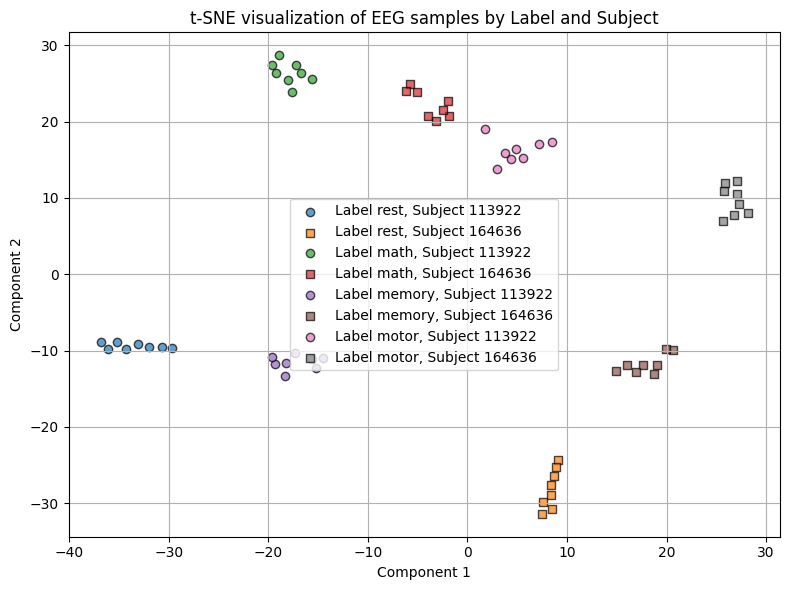

In [25]:
cr_data_train, cr_labels_train, cr_ids_train, cr_data_val, cr_labels_val, cr_ids_val = concat_as_samples('Cross/train_ds_norm')
print(np.shape(cr_data_train))
print(np.shape(cr_data_val))
print(cr_labels_train)

# Flatten the data
X_train = cr_data_train.reshape(len(cr_data_train), -1)
X_val = cr_data_val.reshape(len(cr_data_val), -1)
print(np.shape(X_train))

# Encode string labels to integers
le = LabelEncoder()
y_train = le.fit_transform(cr_labels_train)
y_val = le.transform(cr_labels_val)
print(y_train)
print(y_val)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

input_dim = X_train.shape[1]
num_classes = len(set(y_train))
model = MulticlassLogisticRegression(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    print(val_outputs)
    _, val_predictions = torch.max(val_outputs, 1)
    print('True classes     :', y_val_tensor)
    print('Model predictions:', val_predictions)
    accuracy = (val_predictions == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {accuracy.item():.4f}')

# Combine train and val for visualization
X_combined = np.vstack([X_train, X_val])
labels_combined = cr_labels_train + cr_labels_val
cr_ids_combined = cr_ids_train + cr_ids_val

# Optional: PCA first for speed
X_combined_pca = PCA(n_components=10).fit_transform(X_combined)

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X_combined_pca)

# Plot
plt.figure(figsize=(8, 6))
subjects = list(set(cr_ids_combined))
markers = ['o', 's']

for label in set(labels_combined):
    for i, subject in enumerate(subjects):
        idx = [j for j, (l, s) in enumerate(zip(labels_combined, cr_ids_combined)) if l == label and s == subject]
        plt.scatter(
            X_tsne[idx, 0], X_tsne[idx, 1],
            label=f"Label {label}, Subject {subject}",
            alpha=0.7,
            marker=markers[i % len(markers)],
            edgecolors='k'  # Optional: black edge for contrast
        )

plt.legend()
plt.title("t-SNE visualization of EEG samples by Label and Subject")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

class EEGConvNet(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super(EEGConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.act3 = nn.ReLU()
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=1)

        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [36]:
def train(train_loader, val_loader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EEGConvNet(in_channels=248, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_train_loss:.4f},  Val Loss: {epoch_val_loss:.4f},  Val Acc: {val_accuracy:.4f}")

    model.eval()
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_trues.append(y_batch.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_trues = torch.cat(all_trues, dim=0)
    final_acc = (all_preds == all_trues).float().mean().item()
    print(f"\nFinal Validation Accuracy: {final_acc:.4f}")
    print("True classes     :", all_trues)
    print("Model predictions:", all_preds)

In [39]:
def get_dataloaders(X_train, y_train, X_val, y_val, batch_size=32):
    le = LabelEncoder()
    y_train = le.fit_transform(cr_labels_train)
    y_val = le.transform(cr_labels_val)
    num_classes = len(le.classes_)

    X_train_tensor = torch.tensor(cr_data_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(cr_data_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    batch_size = 16
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, num_classes

In [40]:
train_loader, val_loader, num_classes = get_dataloaders(cr_data_train, cr_labels_train, cr_data_val, cr_labels_val)

train(train_loader, val_loader, num_classes)

Epoch 1/10  Train Loss: 1.2355,  Val Loss: 1.1218,  Val Acc: 0.7500
Epoch 2/10  Train Loss: 0.5817,  Val Loss: 0.7734,  Val Acc: 0.8750
Epoch 3/10  Train Loss: 0.3213,  Val Loss: 0.4865,  Val Acc: 1.0000
Epoch 4/10  Train Loss: 0.1538,  Val Loss: 0.2610,  Val Acc: 1.0000
Epoch 5/10  Train Loss: 0.1488,  Val Loss: 0.1128,  Val Acc: 1.0000
Epoch 6/10  Train Loss: 0.0449,  Val Loss: 0.0486,  Val Acc: 1.0000
Epoch 7/10  Train Loss: 0.0691,  Val Loss: 0.0228,  Val Acc: 1.0000
Epoch 8/10  Train Loss: 0.3268,  Val Loss: 0.0137,  Val Acc: 1.0000
Epoch 9/10  Train Loss: 0.0466,  Val Loss: 0.0142,  Val Acc: 1.0000
Epoch 10/10  Train Loss: 0.1003,  Val Loss: 0.0163,  Val Acc: 1.0000

Final Validation Accuracy: 1.0000
True classes     : tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1])
Model predictions: tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1])


In [41]:
train_loader, val_loader, num_classes = get_dataloaders(data_train, labels_train, data_val, labels_val)

train(train_loader, val_loader, num_classes)

Epoch 1/10  Train Loss: 1.1308,  Val Loss: 1.0757,  Val Acc: 1.0000
Epoch 2/10  Train Loss: 0.4431,  Val Loss: 0.7050,  Val Acc: 1.0000
Epoch 3/10  Train Loss: 0.1508,  Val Loss: 0.3995,  Val Acc: 1.0000
Epoch 4/10  Train Loss: 0.1070,  Val Loss: 0.1986,  Val Acc: 1.0000
Epoch 5/10  Train Loss: 0.0702,  Val Loss: 0.0886,  Val Acc: 1.0000
Epoch 6/10  Train Loss: 0.0562,  Val Loss: 0.0408,  Val Acc: 1.0000
Epoch 7/10  Train Loss: 0.0415,  Val Loss: 0.0199,  Val Acc: 1.0000
Epoch 8/10  Train Loss: 0.0368,  Val Loss: 0.0111,  Val Acc: 1.0000
Epoch 9/10  Train Loss: 0.0375,  Val Loss: 0.0068,  Val Acc: 1.0000
Epoch 10/10  Train Loss: 0.0283,  Val Loss: 0.0037,  Val Acc: 1.0000

Final Validation Accuracy: 1.0000
True classes     : tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1])
Model predictions: tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1])


# Testing

In [16]:
# downsample test data
downsample_and_save('Intra/test', 'Intra/test_ds', DOWNSAMPLING_FACTOR, VERBOSE)
downsample_and_save('Cross/test1', 'Cross/test1_ds', DOWNSAMPLING_FACTOR, VERBOSE)
downsample_and_save('Cross/test2', 'Cross/test2_ds', DOWNSAMPLING_FACTOR, VERBOSE)
downsample_and_save('Cross/test3', 'Cross/test3_ds', DOWNSAMPLING_FACTOR, VERBOSE)

# Normalize data
data_train, _ = concat_together('Intra/train_ds', train_val_split=100)
cr_data_train, _ = concat_together('Cross/train_ds', train_val_split=100)
means, stds = get_means(data_train), get_stds(data_train)
cr_means, cr_stds = get_means(cr_data_train), get_stds(cr_data_train)

normalize_and_save('Intra/train_ds', 'Intra/train_ds_norm', means, stds, VERBOSE)
normalize_and_save('Intra/test_ds', 'Intra/test_ds_norm', means, stds, VERBOSE)

normalize_and_save('Cross/train_ds', 'Cross/train_ds_norm', cr_means, cr_stds, VERBOSE)
normalize_and_save('Cross/test1_ds', 'Cross/test1_ds_norm', cr_means, cr_stds, VERBOSE)
normalize_and_save('Cross/test2_ds', 'Cross/test2_ds_norm', cr_means, cr_stds, VERBOSE)
normalize_and_save('Cross/test3_ds', 'Cross/test3_ds_norm', cr_means, cr_stds, VERBOSE)